# Introduction

A growing number of artworks are being created by machines using algorithms without human input these days. As of this project, we aim to train a neural network image classifier to detect whether the given paintings are AI or human-generated in which human classifying ability is considered the baseline.Of course, discriminating between AI-generated and human-generated art isn't straightforward. It involves deciphering subtle nuances in style, strokes, and artistic choices, which can be a complex task even for human experts.

This project would bring multiple real-world advantages, one of which is the ability to discern AI-generated art from human-generated art could have practical applications in areas such as copyright protection, authentication of artworks, and even in the development of new AI-generated art styles.

To get started, We used a dataset from DiffusionDB and WikiArt, and once filtered and preprocessed, we trained the model using a CNN architecture. Tuning the model and applying more advanced methods, if necessary, will be the next steps.

# Loading and preparing the Data

As previously indicated, two data sets are used to train this model. The WikiArt dataset, which is sliced based on movements and genres related to specific works of art, containing real paintings from actual artists, and the DiffusuinDB, containing millions of AI-generated images and the prompts that were used to create them. To keep the images that meet the requirements of this project and make a fair, balanced comparison of the images, we need to filter the images based on specific words in the prompts. It means keeping the prompts that include words like "painting" or the name of an artist and excluding the ones that include words like "digital" and "3D", which makes the images easily recognizable by human eyes.

The next step is cropping the images. Clearly, the sizes of the actual paintings or the AI-generated ones are not fully compatible and need to be matched. Our approach involves cropping a random square of 256 pixels by 256 pixels to ensure matching dimensions, more straightforward computation, and covering different parts of the artwork (instead of only focusing on the center of each painting.)

#Data Retrival Code for WikiArt

The code below is to obtain the 'Wikiart Dataset,' which contains paintings from human artists, for use in our project.

[WikiArt Dataset Retrival Code](https://colab.research.google.com/drive/1WYA-sdHHdf7feagV0UQ7xvSJigqrcKRh?usp=sharing)

[Wikiart Source](https://huggingface.co/datasets/huggan/wikiart)

# Data Retrival Code for DiffusionDB

The code below is to obtain the 'DiffusionDB Dataset,' which contains AI-generated paintings, for use in our project.

[DiffusionDB Dataset Retrival Code](https://colab.research.google.com/drive/10CF_aH9Uis7DAnLld_v373NySh4gYI3e?usp=sharing)

[DiffusionDB Source](https://huggingface.co/datasets/poloclub/diffusiondb)

# Data Preprocessing Code

Preprocess the image dataset:
Cropped all the images to 256x256
Convert all the images to JPG format with RGB color

[Preprocessing Code](https://colab.research.google.com/drive/1kzVrV-jWjlGkT17aDZxx8REl0eIzzrpo?usp=sharing)

# Progress Report
[Progress Report](https://colab.research.google.com/drive/15m2_JITyqmSPxC-peHJE09XRKxSQLTeA?usp=sharing)

# Config and Setup

## Imports

In [ ]:
# import utils modules
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import pdb
import numpy as np
import pandas as pd

# import torch related modules
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.io import read_image

# import sklearn related modules
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Config

In [ ]:
# pytorch gpu config
seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
  device = torch.device("cuda")
  torch.cuda.manual_seed_all(seed)
else:
  device = torch.device("cpu")
print(device)

cuda


## Downloading and Extracting Data
The creation of these datasets is described in the following notebooks:
*   [DiffusionDB Data](https://github.com/JensenZhaoUT/MIE1517_Project/blob/main/EDA%20-%20Generated.ipynb)
*   [WikiArt Data](https://github.com/JensenZhaoUT/MIE1517_Project/blob/main/WikiArt%20EDA.ipynb)



In [ ]:
# download the datasets to working directory
!gdown 1M-RNViW7mhnedbFxwdrOIW5Y46Eri8sY # diffusiondb_256
!gdown 1VVySTFhHVLipFTZoHKv3J9jokjMxXvBa # paintings_256

# create directories for data and unzip archives
!mkdir -p /content/diffusiondb
!mkdir -p /content/wikiart
!unzip -u /content/cropped_diffusiondb_256.zip -d /content/diffusiondb
!unzip -u /content/cropped_paintings_256.zip -d /content/wikiart

## Creating Custom Dataset

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, directory, label, max_images=None):
        self.directory = directory
        self.label = label
        self.images = [file for file in os.listdir(directory) if file.endswith('.jpg')]
        self.transform = transforms.ToTensor()  # Define the transform here

        # If max_images is set, randomly select a subset of images
        if max_images is not None and max_images <= len(self.images):
            self.images = random.sample(self.images, max_images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.images[idx])
        image = Image.open(img_path)
        image = self.transform(image)  # Transform the image to a tensor
        # load image with gpu if available
        if torch.cuda.is_available():
            image = image.to(torch.device('cuda:0'))
        return image, self.label


# Determine the number of images in the smaller dataset
num_images_in_smaller_dataset = len([file for file in os.listdir('/content/diffusiondb') if file.endswith('.jpg')])

# Create dataset with true and false labels
dataset_false = CustomImageDataset('/content/diffusiondb', 0, max_images=num_images_in_smaller_dataset)
dataset_true = CustomImageDataset('/content/wikiart', 1)

# Concat datasets into one
combined_dataset = ConcatDataset([dataset_false, dataset_true])

In [ ]:
# Train-Validation-Test Split
length_of_combined_dataset = len(combined_dataset)
print(f'Length of dataset: {length_of_combined_dataset}')

# define split size
train_size = int(0.7 * length_of_combined_dataset)  # 70% for training
val_size = int(0.1 * length_of_combined_dataset)   # 10% for validation
test_size = length_of_combined_dataset - train_size - val_size  # Remaining 20% for testing

# perform the split
train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])

Length of dataset: 27642


# Model

## Model Definition

In [ ]:
class MyConvNet(nn.Module):
  def __init__(self, lr=0.01, criterion=nn.BCELoss):
    super(MyConvNet, self).__init__()

    # define params
    self.lr = lr
    self.criterion = criterion()


    # build the encoder and classifier
    self.encoder = self.build_encoder()
    self.classifier = self.build_classifier()


  def build_encoder(self):
    encoder = nn.Sequential(
      nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 5, stride = 2, padding = 0), # (8,254,254) / (8,126,126)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 4, stride = 1, padding = 0), # (8, 251, 251) / (8,123,123)
      nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = 9, stride = 2, padding = 0), # (10,122,122) / (10,58,58)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 4, stride = 1 , padding = 0), # (10, 119, 119) / (10,55,55)
      )
    return encoder

  def build_classifier(self):
    classifier = nn.Sequential(
      nn.Flatten(start_dim=1),
      nn.Linear(10*55**2, 128),
      nn.ReLU(),
      nn.Linear(128, 1),
      nn.Sigmoid()
    )
    return classifier


  def forward(self, img):
    return self.classifier(self.encoder(img.to(torch.float)))

  def train(self, data, val_data, n_epochs=20, batch_size=15, optimizer=torch.optim.Adam):
    # read params and assign
    self.batch_size = batch_size
    train_loader = DataLoader(dataset=data, shuffle=True, batch_size=self.batch_size)
    val_loader = DataLoader(dataset=val_data, shuffle=True, batch_size=self.batch_size)

    # define optimizer
    self.optimizer = optimizer(self.parameters(), lr = self.lr)
    n_training_steps = len(train_loader)
    n_val_steps = len(val_loader)


    train_losses_epochs = []
    val_losses_epochs = []
    train_accuracy_epochs = []
    val_accuracy_epochs =[]

    for epoch in range(n_epochs):
      output = []
      batch_accuracies = []
      train_losses = []
      # training loop
      for i, (x_train, y_train) in enumerate(train_loader):
        # fix typing of labels
        y_train = y_train.type(torch.FloatTensor).unsqueeze(1)
        # make sure we are using cuda
        if torch.cuda.is_available():
          x_train = x_train.to(torch.device('cuda:0'))
          y_train = y_train.to(torch.device('cuda:0'))
        # forward step
        y_pred = self.forward(x_train)
        # get loss
        loss = self.criterion(y_pred, y_train)

        # backprop
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # add outputs to list
        output.append(y_pred)
        # add loss to list
        train_losses.append(loss.item())

        # get accuracy
        correct = (y_pred.round() == y_train).type(torch.float).sum().item()
        accuracy_batch = 100*correct/len(x_train)
        batch_accuracies.append(accuracy_batch)

        # print batch info
        if (i+1 == n_training_steps):
          avg_loss = sum(train_losses)/len(train_losses)
          # add average loss to training losses
          train_losses_epochs.append(avg_loss)
          # get accuracy of epoch
          accuracy = sum(batch_accuracies)/len(batch_accuracies)
          train_accuracy_epochs.append(accuracy)
          # print current epoch info
          print(f'Epoch {epoch+1}/{n_epochs} : Train Accuracy: {accuracy:.2f}%, Avg Loss: {avg_loss:.4f}')


      # validation loop
      batch_accuracies = []
      val_losses = []
      for i, (x_val, y_val) in enumerate(val_loader):
        # fix typing of labels
        y_val = y_val.type(torch.FloatTensor).unsqueeze(1)
        if torch.cuda.is_available():
          x_val = x_val.to(torch.device('cuda:0'))
          y_val = y_val.to(torch.device('cuda:0'))
        # forward step
        y_val_pred = self.forward(x_val)
        # get loss
        loss = self.criterion(y_val_pred, y_val)
        # get accuracy
        correct = (y_val_pred.round() == y_val).type(torch.float).sum().item()
        accuracy_batch = 100*correct/len(x_val)
        batch_accuracies.append(accuracy_batch)
        val_losses.append(loss.item())

        if (i+1 == n_val_steps):
          # get loss and accuracy
          avg_loss = sum(val_losses)/len(val_losses)
          accuracy = sum(batch_accuracies)/len(batch_accuracies)
          val_accuracy_epochs.append(accuracy)
          # add average loss to validation losses
          val_losses_epochs.append(avg_loss)
          print(f'Epoch {epoch+1}/{n_epochs} : Validation Accuracy: {accuracy:.2f}%, Validation Loss: {avg_loss:.4f}')



    return train_losses_epochs, val_losses_epochs, train_accuracy_epochs, val_accuracy_epochs, output

## Model Training

In [ ]:
# init net
net = MyConvNet(lr=0.0005)
# use gpu if available
if torch.cuda.is_available():
  net = net.to(torch.device('cuda:0'))
# training loop
train_losses, val_losses, train_accuracy, val_accuracy, output = net.train(train_dataset, val_dataset, batch_size=3, n_epochs=8)
print('Finished Training')

Epoch 1/8 : Train Accuracy: 75.29%, Avg Loss: 0.5226
Epoch 1/8 : Validation Accuracy: 78.67%, Validation Loss: 0.4690
Epoch 2/8 : Train Accuracy: 81.02%, Avg Loss: 0.4347
Epoch 2/8 : Validation Accuracy: 82.43%, Validation Loss: 0.3961
Epoch 3/8 : Train Accuracy: 83.71%, Avg Loss: 0.3890
Epoch 3/8 : Validation Accuracy: 83.77%, Validation Loss: 0.3886
Epoch 4/8 : Train Accuracy: 84.53%, Avg Loss: 0.3689
Epoch 4/8 : Validation Accuracy: 83.66%, Validation Loss: 0.3897
Epoch 5/8 : Train Accuracy: 86.85%, Avg Loss: 0.3286
Epoch 5/8 : Validation Accuracy: 85.29%, Validation Loss: 0.3781
Epoch 6/8 : Train Accuracy: 88.35%, Avg Loss: 0.2914
Epoch 6/8 : Validation Accuracy: 85.76%, Validation Loss: 0.3576
Epoch 7/8 : Train Accuracy: 89.51%, Avg Loss: 0.2629
Epoch 7/8 : Validation Accuracy: 88.21%, Validation Loss: 0.3381
Epoch 8/8 : Train Accuracy: 91.00%, Avg Loss: 0.2351
Epoch 8/8 : Validation Accuracy: 88.29%, Validation Loss: 0.4411
Finished Training


### Training Visualization

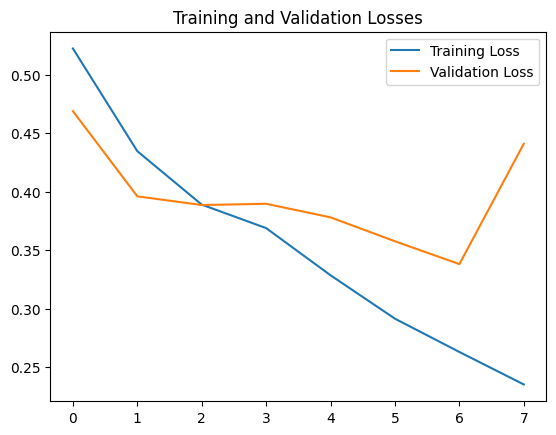

In [ ]:
# plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# add title and legend
plt.legend()
plt.title('Training and Validation Losses')

# display plot
plt.show()

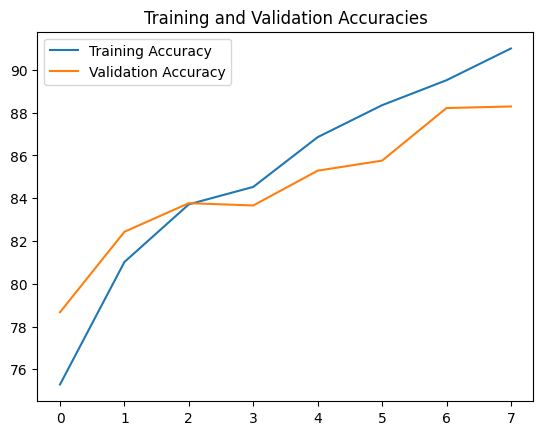

In [ ]:
# plot the training and validation losses
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

# add title and legend
plt.legend()
plt.title('Training and Validation Accuracies')

# display plot
plt.show()

## Model Evaluation

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)

test_preds = []
test_labels = []
total_correct = 0
total_predictions = 0

# test loop
for x_test, y_test in test_loader:
    # fix typing of labels
    y_test = y_test.type(torch.FloatTensor).unsqueeze(1)
    if torch.cuda.is_available():
        x_test = x_test.to(torch.device('cuda:0'))
        y_test = y_test.to(torch.device('cuda:0'))

    # Get predictions
    y_pred = net.forward(x_test)

    # Round predictions to the nearest integer (0 or 1) and convert to CPU for further processing
    test_preds.extend(y_pred.round().type(torch.int).cpu().numpy().flatten().tolist())

    # Convert true labels to CPU and add to the list
    test_labels.extend(y_test.cpu().numpy().flatten().tolist())

    # Calculate number of correct predictions
    correct = (y_pred.round() == y_test).type(torch.float).sum().item()
    total_correct += correct
    total_predictions += len(x_test)

# Calculate and print test accuracy
test_accuracy = 100 * total_correct / total_predictions
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 89.11%


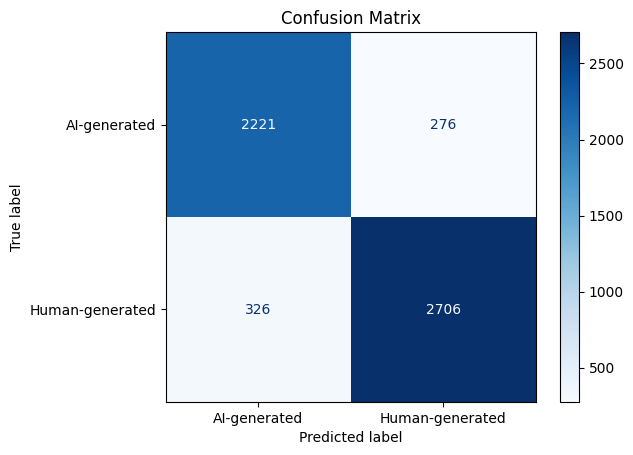

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.89      0.88      2497
         1.0       0.91      0.89      0.90      3032

    accuracy                           0.89      5529
   macro avg       0.89      0.89      0.89      5529
weighted avg       0.89      0.89      0.89      5529



In [ ]:
# create confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["AI-generated", "Human-generated"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()

# display classification report
report = classification_report(test_labels, test_preds)
print("Classification Report:\n", report)

## Analysis & Commentary

**Performance Benchmark** - For general ML tasks, a good bechmark can be human-level performance. The task of recognizing Human vs AI generated images is relatively new, so few thorough studies have been conducted on this topic. However, one peer-reviewed study has been conducted which assess Human performance on this very task. "The role of AI Attribution Knowledge in the Evaluation of Artwork" (Gangadharbatla, 2022) conducted a study with 211 participants through Amazon Mechanical Turk where part classify art as AI or Human generated. On aggregate, the participants had an accuracy rate of just 55%. When looking only at AI-generated art, it was only correctly labelled 43% of the time, while they correctly identified Human-generated art 84% of the time. If we weight these equally, we obtain an overall accuracy score of 63%.

**Performance of our Model** Our model achieves a test accuracy of 89%, far exceeding human level performance. Intuitively, this seems surprising, especially considering the relatively simple 4-layer architecture of our neural network. Even after a single epoch, and with a very small batch size of just 3 images, our model achieves near-human performance.

**Explaining our performance** Our hypotehsis for our model's high performance is that the AI-generated art pieces contain noise that is visually imperceptible to humans, but is easily recognized by a neural network.

**Future Direction** To explore our hypothesis, we can experiment with several factors:
- Model architecture: A simpler model architecture should also be able to pick up on these differences if they are really that "obvious"
- Adding noise: We could attempt to add noise to the data to obfuscate these differences in the datasets
- Out-of-sample testing: We could obtain samples of AI art pieces not generated by stable diffusion, but instead generated by dall-e 3 or other generative image models to see if the model maintains its high level of performance. We could also look at human artworks from other datasets like WikiCommons, etc to evaluate the consistency of the model's performance
- Transfer learning: We can include general purpose image classification models like AlexNet or ResNet as a pre-processing step to determine if these models can also identify differences between, which could lead to significant improvements in training time and thus enable faster parameter tuning of a very simple downstream model.

In [3]:
%%shell
jupyter nbconvert --to html /content/MIE1517_Group10_Progress_Report.ipynb

[NbConvertApp] Converting notebook /content/MIE1517_Group10_Progress_Report.ipynb to html
[NbConvertApp] Writing 766441 bytes to /content/MIE1517_Group10_Progress_Report.html
